# 8-8. 프로젝트: 인물 모드 문제점 찾기

---

-  '인물사진 모드(portrait mode)'로 피사체 외 배경을 흐리게 만들 것이다.
- 사진의 FabFocus 어플에서는 사람이 직접 피사체를 구분해야하지만 모델을 통해 구현해보도록 한다.
- 이미지에서 피사체를 사람과 배경으로 분리하고 배경을 블러 처리 후 사람이미지와 합치면 아웃포커싱한 사진을 얻을 수 있다.

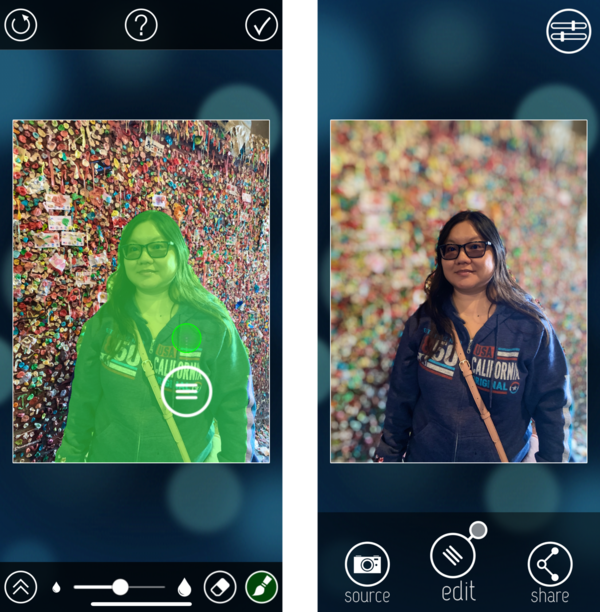

- 사진의 FabFocus 어플에서는 사람이 직접 피사체를 구분해야하지만 모델을 통해 구현해보도록 한다.
- 이미지에서 피사체를 사람과 배경으로 분리하고 배경을 블러 처리 후 사람이미지와 합치면 아웃포커싱한 사진을 얻을 수 있다.

- 흥미를 높이기 위해 사진은 태연 사진을 사용하기로 정했고 스토리텔링을 넣어 봤다.


- 프로젝트 부제목은 **"사랑하는 태연만 보여(I only see my beloved taeyeon)"**이다.
- 해당 모델은 태연을 사랑하기 때문에 태연 사진을 넣었을 때, 태연 외에는 블러 처리를 하도록 한다.
- 태연 외 인물사진을 넣어도 처리가 되겠지만 스토리 흐름을 깨지 않도록 예시 사진은 태연으로 한정한다.
- 태연이 깔끔하게 보일수록 태연을 많이 사랑하는 것이기에 정확한 분류로 사랑의 척도를 표현할 수 있다.
- 그럼 태연을 아주 많이 사랑하는 모델을 만들어보기로 하자.

## Step 1. 인물모드 직접 해 보기

In [1]:
# 필요한 모듈 불러오기
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

이미지사이즈는 (550, 589, 3)이다.


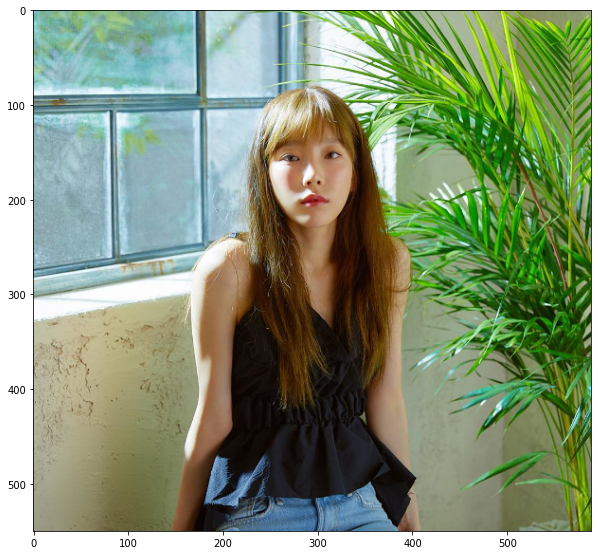

In [2]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image8.png' 
img_orig = cv2.imread(img_path) 
print ('이미지사이즈는 {}이다.'.format(img_orig.shape))

plt.figure(figsize=(10, 10)) # 출력 사이즈 조정

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

- plt.figure(figsize=(10, 10))를 통해 출력 사이즈 조정이 가능하다.
- 태연을 아주 많이 사랑하기 때문에 크게 출력해봤다.
- 역시 태연은 귀엽지만, 태연만 보고 싶기 때문에 태연 외 배경은 지워야겠다고 생각했다.

In [3]:
# DeepLabModel 클래스 만들기
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# 모델 정의와 다운로드, 사전학습된 가중치 불러오기
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir) # 디렉토리와 모든 상위/중간 디렉토리를 생성

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path): # 지정된 경로가 존재하는지 여부를 확인하고 없으면(not) 아래 코드 실행
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path) # URL로 표시된 네트워크 객체를 로컬 파일로 복사

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력하기
img_resized, seg_map = MODEL.run(img_orig) # 여기를 거치면서 이미지 크기가 리사이즈 된다.
print ('원본이미지 사이즈: {}\n리사이즈 마스크 크기: {}\nseg_map.max: {}'.format(img_orig.shape, img_resized.shape, seg_map.max()))

원본이미지 사이즈: (550, 589, 3)
리사이즈 마스크 크기: (479, 513, 3)
seg_map.max: 16


In [6]:
# 구글이 제공한 DeepLab은 PASCAL VOC의 라벨
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
print('DeepLab 모델이 구분 할 수 있는 피사체의 갯수는 {}개 이다.'.format(len(LABEL_NAMES)))

DeepLab 모델이 구분 할 수 있는 피사체의 갯수는 21개 이다.


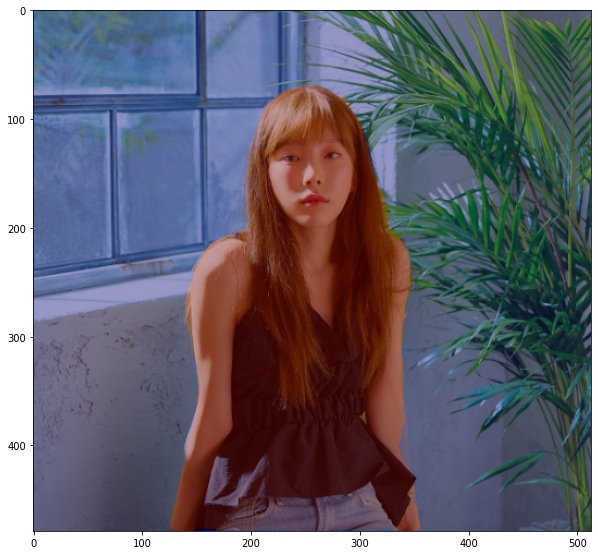

In [7]:
#  사람(person) 라벨(15)를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람(LABEL_NAMES 15번째가 person)만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.figure(figsize=(10, 10))

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 영역 검출을 위해 붉게 보여도 태연은 예쁘다.

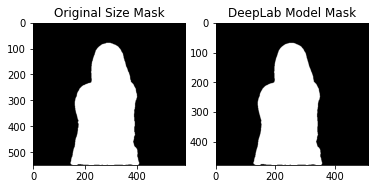

In [8]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

- class DeepLabModel(object)의 run을 거쳐 preprocess을 통과하면서 입력한 이미지 사이즈와 mask 크기가 달라져서 복원을 한다.


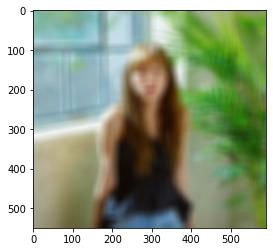

In [9]:
# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (25,25)) #(25,25은 blurring  kernel size를 뜻합니다. 

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 태연을 흐리게 하는 건 마음이 아프지만, 인물사진 모드 구현을 위해 흐린 배경이 필요하다.
- 원본사진(img_orig)을 흐리게 처리 했다.
- 확인해보니 blurring  kernel size가 클수록 더 심하게 흐려진다.

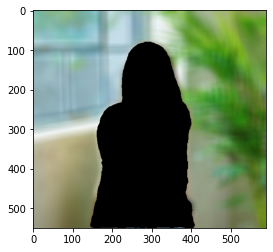

In [10]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

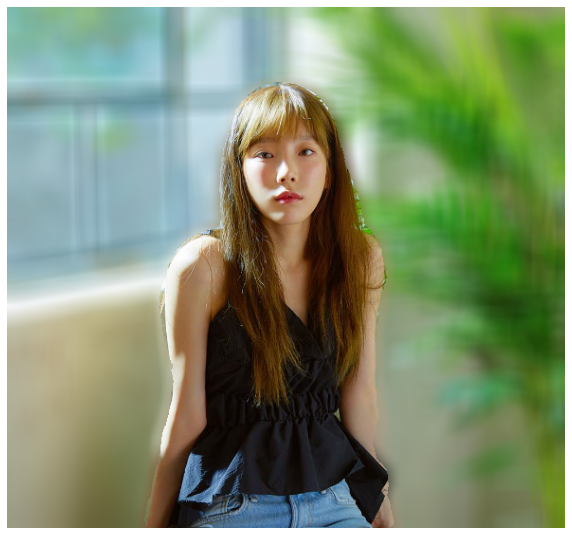

In [11]:
# 배경 영상과 사람 영상을 합치기
plt.figure(figsize=(10, 10))

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

- 완성!
- 배경따윈 눈에 보이지 않는 사랑하는 우리 태연의 사진을 얻을 수 있게 되었다.

---

- 추가로 루브릭 조건을 위해 고양이 사진과 배경 전환 크로마키를 시도해본다.
- 고양이 사진은 태연이 아니니까 빠르게 처리하고 넘어가기로 한다.
- 크로마키도 태연과 배경을 보고 싶은게 아니라 오직 태연만 보고 싶으니 고양이 사진으로 처리한다.
- 강아지였다면 태연이네 애완견 제로의 사진을 활용해서 열심히 참여했을 텐데....

#### ● 고양이 사진

이미지사이즈는 (683, 1024, 3)이다.


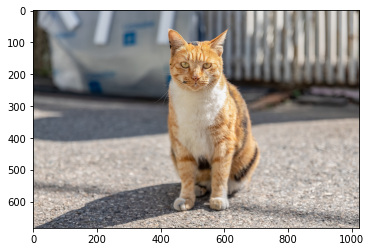

In [12]:
# 이미지 불러오기
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/just_cat.png' 
cat_img_orig = cv2.imread(cat_img_path) 
print ('이미지사이즈는 {}이다.'.format(cat_img_orig.shape))

plt.imshow(cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

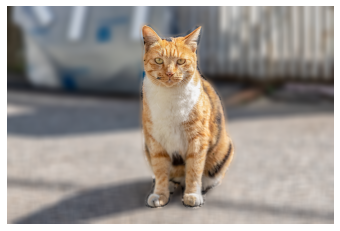

In [13]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력하기
img_resized, seg_map = MODEL.run(cat_img_orig)

#  사람(person) 라벨(15)를 가진 영역만 검출하기
cat_img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
cat_img_mask = seg_map * (255/seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask)를 원래 크기로 복원
cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 배경 흐리게 하기
cat_img_orig_blur = cv2.blur(cat_img_orig, (25,25)) #(25,25)은 blurring  kernel size를 뜻합니다. 

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, cat_img_bg_mask)

# 배경 영상과 고양이 영상을 합치기
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#### ● 배경전환 크로마키사진

- 배경전환 크로마키 사진이 추출한 mask를 다른 배경으로 변화하라는 얘기겠지.
- 태연이 너무 좋지만 나는 태연 외에 아무것도 보고 싶지 않아서 위 고양이사진을 이용한다.
- 기왕이면 태연이 담긴 사진을 배경으로 해서 시도해본다.

이미지사이즈는 (720, 1280, 3)이다.


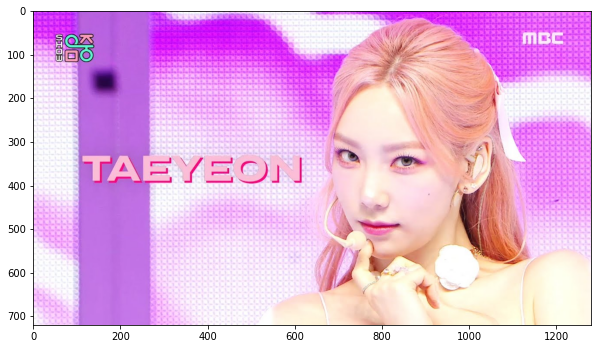

In [14]:
# 배경으로 사용할 사진을 불러온다
weekend_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image11.png' 
weekend_orig = cv2.imread(weekend_path)
print ('이미지사이즈는 {}이다.'.format(weekend_orig.shape))

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(weekend_orig, cv2.COLOR_BGR2RGB))
plt.show()

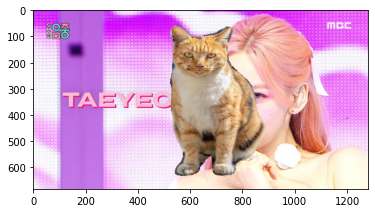

In [15]:
# 이미지, 배경사진, 이미지 mask 리사이즈
cat_resized = cv2.resize(cat_img_orig, (weekend_orig.shape[1], cat_img_orig.shape[0]))
weekend_img_resized = cv2.resize(weekend_orig, (weekend_orig.shape[1], cat_img_orig.shape[0]))

cat_img_mask_resized = cv2.resize(cat_img_mask_color, (weekend_orig.shape[1], cat_img_orig.shape[0]))

# 배경 영상과 고양이 영상을 합치기
cat_weekend_concat = np.where(cat_img_mask_resized == 255, cat_resized, weekend_img_resized)

plt.imshow(cv2.cvtColor(cat_weekend_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 우선 배경과 이미지를 합성하긴 했지만 여기서 만족할 수 없다.
- 왜냐하면 건방진 고양이가 태연을 가리고 있어서 위치를 변경할 것이다.
- 이미지 사이즈를 보니 고양이 사진과 태연 사진 크기가 비슷하다.
- 좌측으로 이동과 동시에 고양이가 태연보다 크면 별로니까 고양이 사이즈도 작게 조절 할 것이다.
- 고양이가 올바른 위치에 있도록 바로 수정해야지.

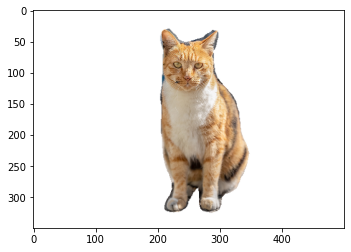

In [16]:
# 고양이 사진 추출 및 리사이즈
just_cat = np.where(cat_img_mask_color==255, cat_img_orig, 255)
just_cat = cv2.resize(just_cat, dsize=(500, 350), interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(just_cat, cv2.COLOR_BGR2RGB))
plt.show()

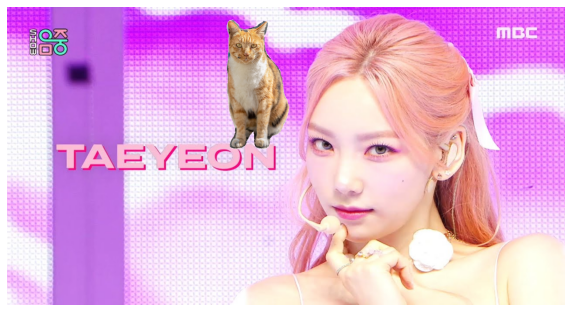

In [17]:
# 리사이즈 사진 위치지정 및 배경과 합성하기
refined_y = 0
refined_x = 300

sticker_area = weekend_img_resized[refined_y:refined_y+just_cat.shape[0], refined_x:refined_x+just_cat.shape[1]]
weekend_img_resized[refined_y:refined_y+just_cat.shape[0], refined_x:refined_x+just_cat.shape[1]] = np.where(just_cat==255,sticker_area,just_cat).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(weekend_img_resized, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

- 위치를 고민해봤는데 태연이름 끝나는 부분 위쪽이 젤 귀엽다.
- 고양이가 방해될 것같아 작게 사이즈를 줄이고 왼쪽 상단에 넣는 것을 목표로 했다.
- refined_y와 refined_x 값 조정을 통해 위치를 쉽게 바꿀 수 있다.
- 다시 봐도 위캔드 음중 태연은 상큼새침하다.

## Step 2. 사진에서 문제점 찾기

- 문제를 하나 발견했다.
- 결과 값을 위해서라도 이건 큰 문제임에 틀림없다.
- 아무리 그래도 태연이 포함된 이미지를 흐리게 하다니 난 정말 미친게 틀림없다.
- 다른 고양이 사진은 아무 상관없다.
- 이 문제를 해결하기 위해 **태연을 제외한 부분만 흐리게** 해야갰다.

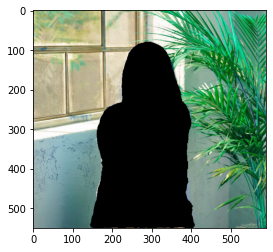

In [18]:
# 사람과 분리된 이미지를 사용하고 해당 이미지를 흐리게 만든다.
i_dont_want_to_hurt_her = cv2.bitwise_and(img_orig, img_bg_mask)

plt.imshow(i_dont_want_to_hurt_her) # 어떤 이미지가 흐려질지 확인을 위해 출력하기

img_bg_blur2 = cv2.blur(i_dont_want_to_hurt_her, (25,25)) # 출력된 이미지를 흐리게 하기

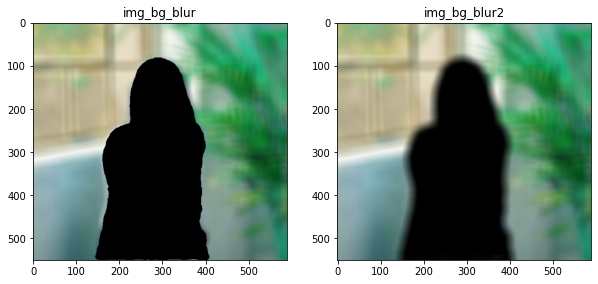

In [19]:
# 적용 전후 확인해보기
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(img_bg_blur)
plt.title('img_bg_blur')

plt.subplot(122) 
plt.imshow(img_bg_blur2)
plt.title('img_bg_blur2')

plt.show()

- 생각한 아이디어를 눈으로 확인해봤다.

- 태연과 함께 흐리게 처리한 뒤 세그멘테이션 마스크를 이용해서 배경을 추출한 img_bg_blur는 왠지 기분이 나쁘다.
- 이렇게 보니 태연은 실루엣도 귀엽다.
- 검은색 영역이 흐리게 되긴 했지만 img_bg_blur2에선 태연에게는 아무런 영향을 안끼쳤다고 생각하니 봐줄만하다.

In [20]:
# 배경 영상과 사람 영상을 합치기
img_concat2 = np.where(img_mask_color==255, img_orig, img_bg_blur2)

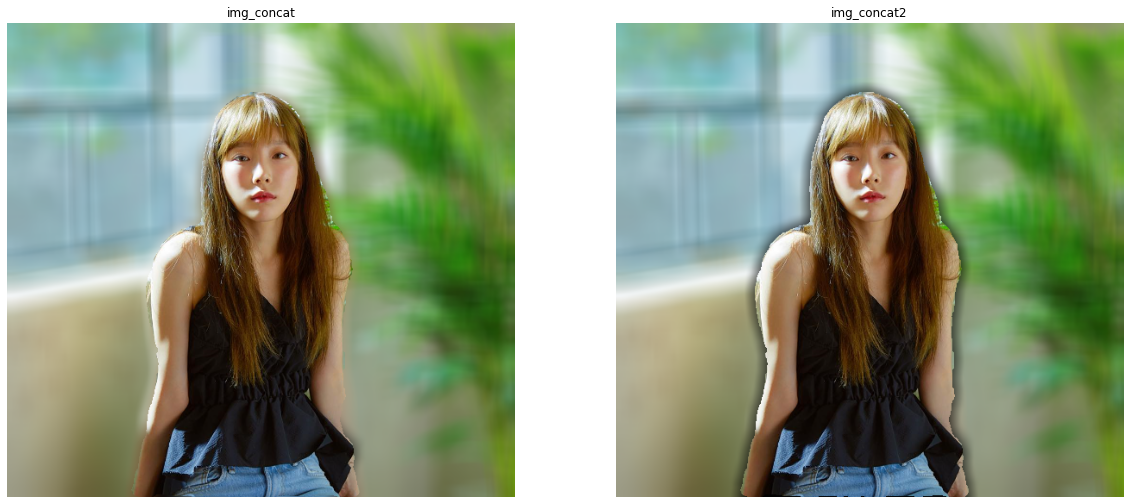

In [21]:
# 완성 이미지 비교해보기
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('img_concat')
plt.axis('off')

plt.subplot(122) 
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.title('img_concat2')
plt.axis('off')

plt.show()

- 이미지를 비교해보니 태연과 함께 흐리게 한 첫번째 결과가 원본과 자연스럽게 연결되어 깔끔한 것 같다.
- 다만 blurring  kernel size를 크게하면 첫번째 결과도 자연스럽진 않다.


- 왼쪽 이미지는 태연과 배경을 분리할 때 검은색 처리된 부분이 흐리게 되서 그런지 검은 영역이 보이며 경계썬이 더 명확해 졌다.
- 후광 같기도 하고 그림자 처리처럼 강조된 것 같아 나쁘지 않다.
- 아무도 태연에게 상처 줄 수 없다. 우리 태연 절대 지킬것이다.
- 그렇기에 나는 두번째 결과물을 프로젝트로 제출할 것이다.

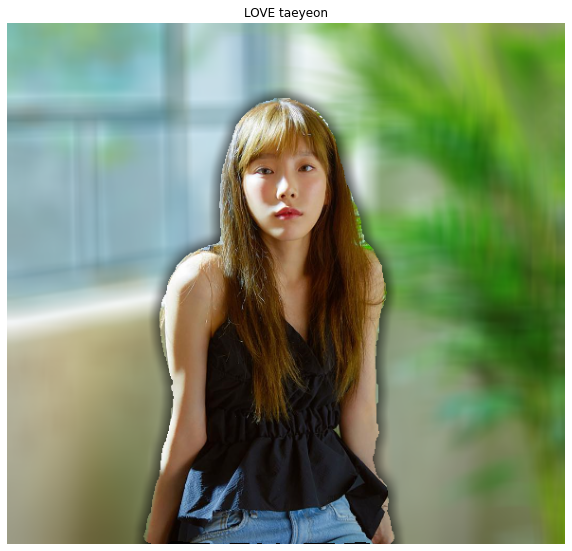

In [22]:
# 결과물 확인
plt.figure(figsize=(10, 10))

img_concat2 = np.where(img_mask_color==255, img_orig, img_bg_blur2)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.title('LOVE taeyeon')
plt.axis('off')
plt.show()

- 두번째 완성!
- 태연이에게 아무런 해를 끼치지 않았다고 하니 완성된 이미지가 더욱 마음에 든다.

---

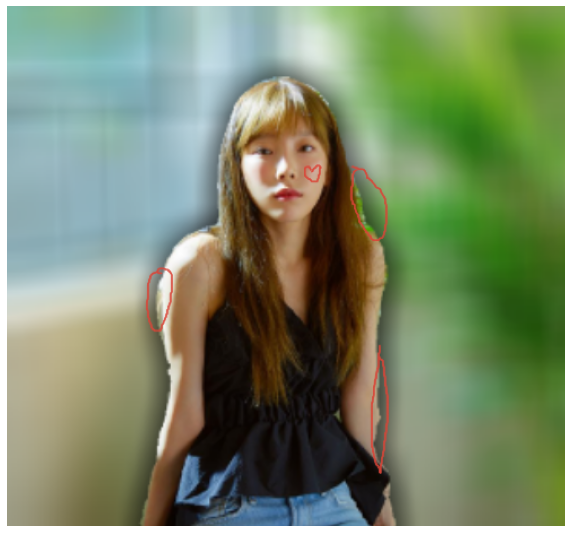

In [23]:
# 문제점 확인해보기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image13.png' # 위 이미지는 blurring kernel size가 (50,50)으로 지정했다.
img_orig = cv2.imread(img_path) 

plt.figure(figsize=(10, 10)) # 출력 사이즈 조정

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

- 위에 있는 태연이를 23252352시간 보고 있다보니 아쉬운 점을 발견했다.
- 물론 태연은 아무 문제 없고 소중하고 사랑스럽다.
- 문제는 태연과 배경이 **부드럽지 않게 나뉜 점**에 있다.
- 빨간색으로 표시된 부분을 보면 태연이와 배경이 정확하게 분류되지 않았다.
- 얼굴의 하트는 귀여워서 넣었다❤️
- 보면 볼 수록 내가 태연을 사랑하는 마음이 완벽하게 표현되지 않은 것 같다.
- 외곽 부분이 좀더 부드럽고 정확하게 분류해서 내 마음을 표현할 것이다.
  
  
- 기왕이면 새로운 기운을 얻기위해 다른 사진으로 시도해보고 위에 있는 사진도 잘 구분할 수 있도록 시도해본다.

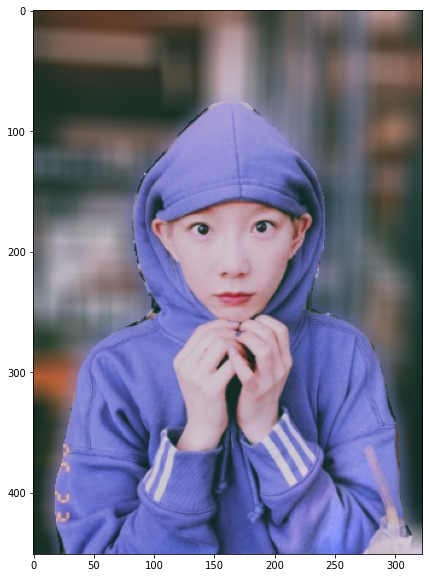

In [24]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image10.png' 
img_orig = cv2.imread(img_path)

# 첫 단계에서 준비한 이미지를 네트워크에 입력하기
img_resized, seg_map = MODEL.run(img_orig)

#  사람(person) 라벨(15)를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람(LABEL_NAMES 15번째가 person)만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (25,25)) #(25,25)은 blurring  kernel size를 뜻합니다. 

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

# 배경 영상과 사람 영상을 합치기
plt.figure(figsize=(10, 10))

img_concat3 = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

- 위 사진은 태연을 잘 구분했지만 역시 기존 방식으론 경계가 불완전하게 나뉜다.
- 사진을 더 잘 분류해서 사랑을 표현하고 싶은데 왜 안되는거지...포기하지 않을거야
- 태연을 향한 내 사랑은 이정도가 아니니까 또 다시 도전해야지

---

## Step 3. 해결 방법을 제안해 보기

- 아무리 생각해도 해결이 안되서 포기가 안된다.
- 아까 해결 못한 부분을 해결하고자 한다.
 
- 위에서 사용한 방식에는 **블러처리된 배경과 경계선이 나뉘어 부자연스럽다는 문제점**이 있어 내 사랑만큼 표현 안된다.
- 태연이가 내 사랑을 몰라준다고 해도 내가 태연을 사랑하니까 이 마음을 표출하고 싶다.
  
  
- 방법론적으로 생각해봤을 때 분류를 더 명확히 하는 좋은 모델을 쓰면 해결이 될 것 같기도 하다.
- 우선 [PEBpung님의 깃허브](https://github.com/PEBpung/Aiffel/blob/master/Project/Exploration/E14.%20Image%20segmentation%EC%9D%84%20%EC%9D%B4%EC%9A%A9%ED%95%9C%20Portrait%20mode%20%EB%A7%8C%EB%93%A4%EA%B8%B0..ipynb)에서 본 **가우시안블러**를 사용해서 해결해 볼 것이다.

In [25]:
# img_mask_up의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
orig_Gblur = cv2.GaussianBlur(img_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
image_blur = img_Gmask*img_orig.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
img_bg_mask = (1-img_Gmask)*orig_Gblur.astype(np.float32)
img_output = (image_blur+img_bg_mask).astype(np.uint8)

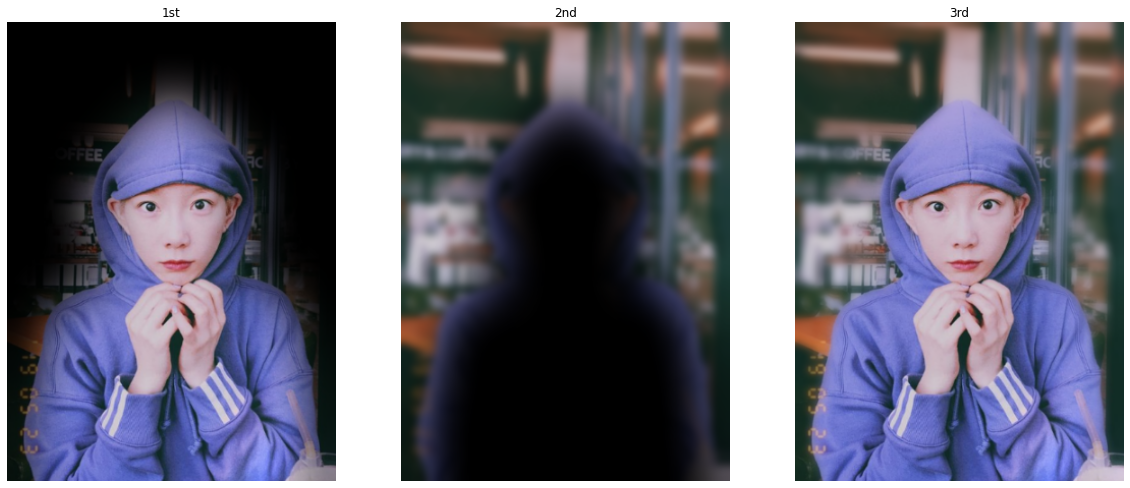

In [26]:
# GaussianBlur 처리한 부분을 확인하기
fig = plt.figure(figsize=(20, 10)) 

ax = plt.subplot(131)
plt.imshow(cv2.cvtColor(image_blur.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('1st')
plt.axis('off')
ax = plt.subplot(132)
plt.imshow(cv2.cvtColor(img_bg_mask.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('2nd')
plt.axis('off')
ax = plt.subplot(133)
plt.imshow(cv2.cvtColor(img_output,cv2.COLOR_BGR2RGB))
plt.title('3rd')
plt.axis('off')
plt.show()

- 순차적으로 보면 1번 사진은 가우시안 블러처리한 마스크와 원본사진을 더한 이미지이다.
- 2번째 사진은 Blur 처리한 원본에서 배경만 가져온 것이다.
- 3번째 사진은 1번과 2번을 합쳐 만든 완성 이미지이다.

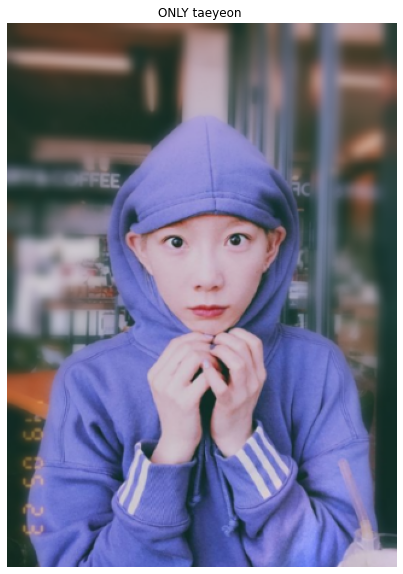

In [27]:
# 결과물 확인
plt.figure(figsize=(10, 10))

plt.imshow(cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB))
plt.title('ONLY taeyeon ')
plt.axis('off')
plt.show()

- 세번째 완성!
- 이제서야 진짜 태연을 사랑하는 나의 마음이 표현되는 것 같다.
- 처음 시도해봤던 이미지도 다시 한번더 시도해 보자!

In [28]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image8.png' 
img_orig = cv2.imread(img_path)

# 첫 단계에서 준비한 이미지를 네트워크에 입력하기
img_resized, seg_map = MODEL.run(img_orig)

#  사람(person) 라벨(15)를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람(LABEL_NAMES 15번째가 person)만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# img_mask_up의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
orig_Gblur = cv2.GaussianBlur(img_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
image_blur = img_Gmask*img_orig.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
img_bg_mask = (1-img_Gmask)*orig_Gblur.astype(np.float32)
img_output2 = (image_blur+img_bg_mask).astype(np.uint8)

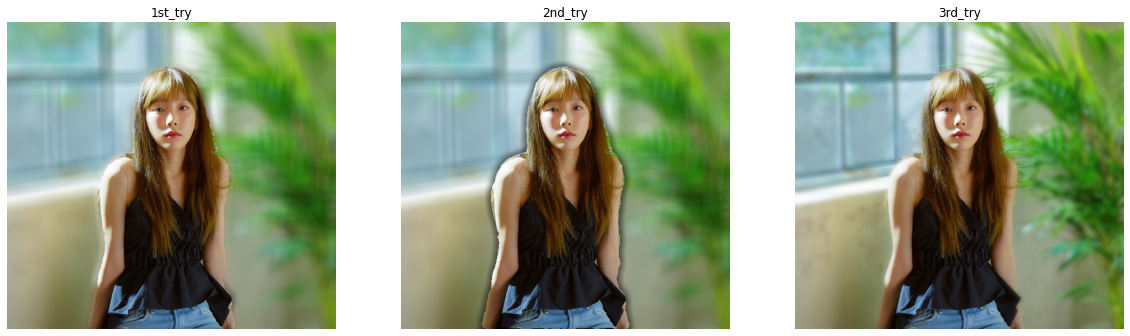

In [29]:
# GaussianBlur 전후 비교해서 확인하기
fig = plt.figure(figsize=(20, 10)) 


ax = plt.subplot(131)
plt.imshow(cv2.cvtColor(img_concat.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('1st_try')
plt.axis('off')

ax = plt.subplot(132)
plt.imshow(cv2.cvtColor(img_concat2.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('2nd_try')
plt.axis('off')

ax = plt.subplot(133)
plt.imshow(cv2.cvtColor(img_output2,cv2.COLOR_BGR2RGB))
plt.title('3rd_try')
plt.axis('off')

plt.show()

- 여러번의 시도 끝에 확실히 사진이 자연스러워진 것을 알 수 있다.
- 가우시안블러 사진만큼 앞에 사진들의 흐리기도 조정할 수 있지만 경계선에 대한 부분을 확실히 하기 위해 25,25로 조정했다.
- 이제 어떤 사진이 오더라도 나는 태연만 바라볼 수 있게 되서 기쁘다.

# 사랑하는 태연만 보여(I only see my beloved taeyeon) 완성

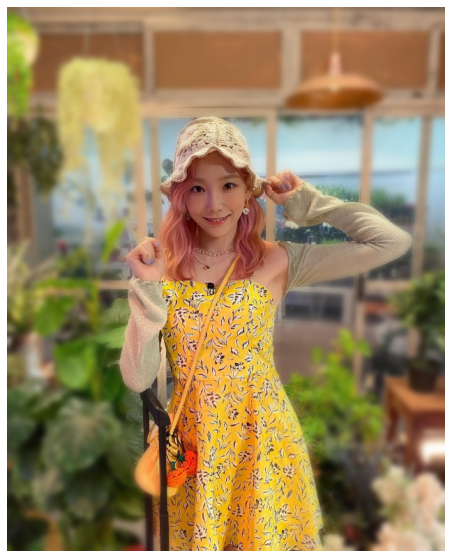

In [30]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image4.png' 
img_orig = cv2.imread(img_path)

# 첫 단계에서 준비한 이미지를 네트워크에 입력하기
img_resized, seg_map = MODEL.run(img_orig)

#  사람(person) 라벨(15)를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람(LABEL_NAMES 15번째가 person)만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# img_mask_up의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
orig_Gblur = cv2.GaussianBlur(img_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
image_blur = img_Gmask*img_orig.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
img_bg_mask = (1-img_Gmask)*orig_Gblur.astype(np.float32)
img_output3 = (image_blur+img_bg_mask).astype(np.uint8)

# 이미지 출력
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_output3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

- 새로운 사진에도 정상적으로 반영되는 걸 확인했기에 프로젝트 제출을 해야겠다.
- 태연 덕분에 공부도 하고 프로젝트도 잘 제출하고 태연이 최고다.

---

##  semantic segmentation mask의 오류

- 위 사진들을 보더라도 사람과 배경의 구분이 정확하지 않다.
- 바로 위 사진의 가방을 본다면 사람이 착용하고 있는 가방이기에 함께 분류가 되도 좋지 않을까 싶다.

1. 배경에 다양한 깊이의 개체가 포함되어 있어도 흐림 효과의 양이 균일하다.
2. 사람이 아니여도 사람 가까이에 있으면 배경이 아니게 될 가능성이 높다.(포커싱 오류)

##  semantic segmentation mask의 오류 해결 방안

- 루브릭의 상세기준을 보니 추가적인 depth 정보를 활용하여 오류 보안의 솔루션을 제시하라는 부분에서 키워드를 얻어 찾아 보았다.
- 노드 8-7에서도 인물과 배경의 거리차이가 있고 거리가 일정할 수록 자연스러워 보인다는 설명도 함께 참고하였다.
- [Google AI 블로그](https://ai.googleblog.com/2017/10/portrait-mode-on-pixel-2-and-pixel-2-xl.html)에 인물 사진모드에 대한 부분을 토대로 작성했다.

1. 이미지에서 기계학습을 기반으로 전경(사람)과 배경을 구분한다.
2. 각 지점에서 깊이를 아는 것이 도움이 되기에, 깊이를 계산하기 위해  PDAF(Phase-Detect Auto-Focus)픽셀이라는 기술을 사용한다.  
    이 알고리즘은 먼저 하위 픽셀 단위의 정확한 타일 기반 정렬을 수행하여 저해상도 깊이 맵을 생성한 다음 양방향 솔버를 사용하여 이를 고해상도로 보간([interpolates](https://www.howdy-mj.me/react-spring/05-interpolation/))한다.
3. 우리가 얻는 깊이 정보는 특히 저조도(어두운 상태)에서 이미지의 높은 노이즈로 인해 부정확하다.  
    노이즈를 줄이고 깊이 정확도를 개선하기 위해 왼쪽 및 오른쪽 이미지의 버스트를 캡처한 다음 스테레오 알고리즘을 적용하기 전에 정렬하고 평균을 낸다. 
5. 마지막 단계는  기계 학습 기반으로 전경-배경 분할 마스크를 위에서 계산한 깊이 맵과 결합하여 사진의 각 픽셀을 얼마나 흐리게 할 것인지 결정한 뒤 모두 합쳐 결과물을 만든다. 

---

## 루브릭 관련 고려한 점

**1. 인물모드 사진을 성공적으로 제작하였다.**

- 아웃포커싱 효과가 적용된 태연의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.

**2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.**

- 인물사진에서 발생한 문제점인 경계선 부자연스럽게 나뉘는 것을 지적한 사진을 제출하였다.

**3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.**

- 인물 경계 부분 계선을 위해 가우시안블러를 사용해서 자연스럽게 표현할 수 있었다.
- 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 솔루션을 작성하였다.


## 회고

1️⃣ 잘한 점:  
- 지난 해커톤 때 쇄빙선이라는 조의 발표에 충격을 받아 컨셉을 잡고 이번 프로젝트를 작성해봤다.  
    (진짜 배를 컨셉으로 잡아서 선원이 선장의 구호를 시작으로 발표했다. 임펙트가 엄청 나서 꼭 해보고 싶었다.) 
    
    
- 처음에는 태연을 사랑하는 모델을 만든다고 작성했는데 모델 수정을 시도하는 과정에서 태연을 사랑하는 팬이 프로젝트를 진행한다는 컨셉으로 수정했다.
- 이상한 사람이나 스토커 같기도 하지만 프로젝트를 하는 동안 재밌어서 모델수정이나 리사이즈하여 합성하는 등 여러가지 시도를 더 많이 해봤다.


- 파일명이나 plt.title도 신경써서 저장했는데, 파일명에서 태연은 my_image이지만 고양이는 just_cat으로 저장했다.
- 또 태연 얼굴이 나온 사진만 figsize를 조정해서 크게 출력하도록 했다.


- 고양이 사진 부분 빠르게 처리한다고 적었지만, 엄청 공들여서 작성했다.
- 안적으면 몰라줄 것 같아 적는 건데 크로마키를 태연+태연으로 합성해도 되는데 스토리텔링을 위해 태연+고양이로 해서 리사이즈,위치변경을 추가했다.


- 컨셉은 이스터에그처럼 생각하고 재미로 읽기를 바라며, 코드부분은 컨셉에 물들지 않도록 작성했다.



- 첫번째 문제점인 사람도 함께 흐리게한 부분을 문제라고 제시해도 되나 싶지만 컨셉에 맞춰서 시도해봤다. 
- 그래서 Step 2. 사진에서 문제점 찾기에서 바로 해결한 코드를 작성했고 이런 방법도 있다고 제시하는 걸로 생각해도 될 것 같다.
- 마스크된 부분을 따로 활용하려고 시도한 점을 생각해보면 그래도 잘한 것 같다.


- 컨셉틱하게 적은 일부를 제외하고 코드도 글도 전체적으로 가독성 좋게 작성하는 것을 신경써봤다.

2️⃣ 어려웠던 점:  
- 기존에 노드에서 제시하는 길이 아닌 새로운 길을 개척해보려고 새로운 모델(Mask_RCNN)로 작성해보려 했으나 실패했다.
- 조금 더 해보려고 하면 계속 실패만 하는데 언제쯤 성공한 코드를 작성해서 올릴지 실행하면 뜨는 에러가 제일 어렵다.
- 시도한 부분을 추가해서 작성할까 했다가 첫번째 블럭부터 오류여서 삭제하였우며, 추후 시도를 위해 참고사이트만 기록해둔다.


- 새로운 사진으로 변경할 때 기존 변수명을 수정하지 않고 그대로 가져다 썼다.
- 그렇게 하니 전체적으로 재실행할 때, 순차적으로 실행할때는 문제가 없지만, 그렇지 않을때는 의도한 바와 다르게 값이 출력될 때가 많았다.
- 이번에는 우선 수정할 수 있는 만큼만 수정했다.
- 다음부터는 처음에 작성할 때 부터 공통적인 사용하는 변수가 아니라면 변수명을 신경써서 작성하도록 할 것이다.

3️⃣ 느낀 점:  
- 새로운 시도는 언제나 재밌다.
- 실패는 성공의 어머니라고 한다. 어머니는 나를 사랑하시지만 약간 엄하신 것 같다.


- 크로마키 사진에서 리사이즈나 합성 등의 부분은 이우용님의 깃허브를 참고했다.
- 다시와서 보면 이전 [카메라 스티커 앱 프로젝트](https://github.com/hyyoo3526/AIFFEL_EXPLORATION/blob/main/EXPLORATION_03/EXPLORATION_IC1_03_camera_sticker_app.ipynb) 코드와 같기에 혼자서 시도해도 될 것 같다.
- 모르면 바로 검색하는 것도 좋지만, 기존에 알고있었는 지 탐색하는 시간을 조금이라도 가져야한다고 느꼈다.


- 인물사진 모드를 태연 외엔 안보이게 한다고 표현한게 재밌었고 진짜 태연 덕에 잘 공부한 것 같다.
- 다음에 비슷한 걸 시도해 볼때는 좀 극단적으로 보일 수 있는 부분을 거부감이 들지 않게 해봐야겠다.

4️⃣ 참고사이트:  
- 코드 [PEBpung님의 깃허브](https://github.com/PEBpung/Aiffel/blob/master/Project/Exploration/E14.%20Image%20segmentation%EC%9D%84%20%EC%9D%B4%EC%9A%A9%ED%95%9C%20Portrait%20mode%20%EB%A7%8C%EB%93%A4%EA%B8%B0..ipynb)
- 코드 [이우용님의 깃허브](https://github.com/dldndyd01/AI_STUDY/blob/master/human_segmentation/human_segmentation.ipynb)
- 추가 시도 모델 [빵형의 개발도상국 유튜브](youtube.com/watch?v=NRB7Mp41f64&t=263s)
- 추가 시도 모델 [Mask_RCNN Original repository](https://github.com/matterport/Mask_RCNN)
- semantic segmentation 관련 자료 [Google AI 블로그](https://ai.googleblog.com/2017/10/portrait-mode-on-pixel-2-and-pixel-2-xl.html)
- 사진출처 [태연 인스타](https://www.instagram.com/Taeyeon_ss/)